In [1]:
import pandas as pd
import os, sys, pandas, pathlib, time
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import random

Image.MAX_IMAGE_PIXELS = None #Throws error if size of images exceeds this number

In [2]:
#Creates dictionary mapping labels(string) to vector(one-hot encoding)
all_labels = list(np.load('materials/UBC-OCEAN_CS640/all_labels.npy'))
num_classes = len(all_labels)
label_dict = defaultdict(lambda: torch.zeros(num_classes))
for i, label in enumerate(all_labels):
    label_dict[label][i] = 1

In [3]:
print(label_dict)

defaultdict(<function <lambda> at 0x000001EB2226B880>, {'HGSC': tensor([1., 0., 0., 0., 0.]), 'EC': tensor([0., 1., 0., 0., 0.]), 'MC': tensor([0., 0., 1., 0., 0.]), 'CC': tensor([0., 0., 0., 1., 0.]), 'LGSC': tensor([0., 0., 0., 0., 1.])})


In [4]:
    # change the size only if necessary
transform = v2.Compose([v2.Resize(256, antialias = True),
                            v2.CenterCrop(224),
                            v2.ToImage(),
                            v2.ToDtype(torch.float32, scale = True),
                            v2.Normalize(mean = [0.4887, 0.4266, 0.4855], std = [0.4212, 0.3790, 0.4169])])

In [5]:
## TODO: create list of transformed images and update dataset class removing transforms

def load_transform_images(folder_path):
    images = {}  # Dictionary to store transformed images

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):  # Check for .jpg files
            img_name = os.path.splitext(filename)[0]  # Extract the name (assuming it's a number)
            print(img_name)
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert image to RGB (if not already)
                transformed_img = transform(img)  # Apply the transformation
                images[img_name] = transformed_img  # Store in dictionary with name as key

    return images

# Example usage
folder_path = 'materials/UBC-OCEAN_CS640/train_images_compressed_80/'
transformed_images = load_transform_images(folder_path)

10077


10143
10252
10469
10548
10642
1080
10896
11263
11417
11431
11557
11559
12222
12244
12442
1252
12522
1289
12902
1295
13364
13387
13526
13987
14039
14051
14127
14312
14401
14424
14532
14542
14617
15139
15188
15209
15221
15231
15293
15470
15486
15583
15671
15742
16042
16064
16209
16325
16494
1666
16876
16986
17067
17174
17291
17365
17416
17487
17637
17738
1774
17854
18014
18138
18547
18607
18810
18813
18896
18981
19030
19157
1925
19255
1952
19569
20205
20312
20329
20670
20858
20882
2097
21020
21232
21303
21373
21432
21445
21910
21929
22155
22221
2227
22290
22425
22489
22654
22740
22924
23523
23796
2391
24023
24507
24563
24617
24759
24991
25561
25604
25792
25928
26025
26124
26190
26533
26603
26644
2666
26862
26950
2706
27245
27249
27315
27747
27851
27950
28028
28066
281
28121
28393
28519
28562
28603
28736
28821
28922
2906
29084
29147
29200
29240
29331
29615
29888
29904
30203
30369
30508
30515
3055
30712
30738
3084
30868
3092
31033
31297
31333
31383
31473
31594
31793
32032
32035
32042
32192

In [ ]:
## Create list of training images and validation images using a split
def split_dataset(images, train_ratio=0.8):
    total_images = len(images)
    train_size = int(total_images * train_ratio)

    # Randomly shuffle the images
    shuffled_items = list(images.items())
    random.shuffle(shuffled_items)

    # Split the images into training and validation sets
    train_images = dict(shuffled_items[:train_size])
    validation_images = dict(shuffled_items[train_size:])

    return train_images, validation_images

train_images, validation_images = split_dataset(transformed_images)


print(f'Number of training images: {len(train_images.keys())}')
print(f'Number of validation images: {len(validation_images.keys())}')
print(f'Type of key: {type(list(train_images.keys())[0])}')
print(f'Type of image: {type(list(train_images.values())[0])}')
print(f'Size of image: {list(train_images.values())[0].size()}')

Number of training images: 344
Number of validation images: 86
Type of key: <class 'str'>
Type of image: <class 'torchvision.tv_tensors._image.Image'>
Size of image: torch.Size([3, 224, 224])


In [ ]:
##TODO: Update dataset to pass in list of images
class CustomDataset(Dataset):
    def __init__(self, csv_file, images, num_classes):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            num_classes (int): Total number of classes.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)

        self.name_to_id = self.labels_frame['image_id'].to_dict()
        self.id_to_name = {int(v):k for k, v in self.name_to_id.items()}
        
        
        self.images = images
        self.image_names = list(self.images.keys())  # List of image names
        self.num_classes = num_classes

    def __len__(self):
        return len(list(self.images.keys()))

    def __getitem__(self, idx):
        image = self.images[self.image_names[idx]]

        label = self.labels_frame.iloc[self.id_to_name[int(self.image_names[idx])], 1]
        #print(self.labels_frame.iloc[self.id_to_name[int(self.image_names[idx])]])
        # Convert label to one-hot encoding
        one_hot = label_dict[str(label)]
        return image, one_hot

In [ ]:
## TODO: Add validation set and update method calls
batch_size = 64

# Create the dataset
train_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', images=train_images, num_classes=num_classes)
validation_dataset = CustomDataset(csv_file='materials/UBC-OCEAN_CS640/train.csv', images=validation_images, num_classes=num_classes)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

# Now you can use this dataloader in your training loop

In [ ]:
#Size of the reshaped first image in the data set
#(RGB * width * height)
print(f'Numer of training examples: {train_dataset.__len__()}')
print(f'Numer of testing examples: {validation_dataset.__len__()}')
print(f'Type of pairing: {type(train_dataset.__getitem__(0))}')
print(f'Number of inputs + outputs: {len(validation_dataset.__getitem__(0))}')
print(f'Size of input: {train_dataset.__getitem__(0)[0].size()}')
print(f'First input(normalized): {train_dataset.__getitem__(0)[0]}')
print(f'First output(one-hot encoding): {train_dataset.__getitem__(0)[1]}')

Numer of training examples: 344
Numer of testing examples: 86
Type of pairing: <class 'tuple'>
Number of inputs + outputs: 2
Size of input: torch.Size([3, 224, 224])
First input(normalized): Image([[[ 0.9439,  0.9346,  0.9346,  ..., -1.1603, -1.1603, -1.1603],
        [ 0.9439,  0.9253,  0.9160,  ..., -1.1603, -1.1603, -1.1603],
        [ 0.9160,  0.9160,  0.8787,  ..., -1.1603, -1.1603, -1.1603],
        ...,
        [ 0.9532,  0.9439,  0.9439,  ..., -1.1603, -1.1603, -1.1603],
        [ 0.9532,  0.9532,  0.9625,  ..., -1.1603, -1.1603, -1.1603],
        [ 0.9532,  0.9439,  0.9532,  ..., -1.1603, -1.1603, -1.1603]],

       [[ 1.0887,  1.0783,  1.0473,  ..., -1.1256, -1.1256, -1.1256],
        [ 1.0783,  1.0370,  1.0163,  ..., -1.1256, -1.1256, -1.1256],
        [ 1.0059,  0.9852,  0.9128,  ..., -1.1256, -1.1256, -1.1256],
        ...,
        [ 1.0990,  1.0887,  1.0887,  ..., -1.1256, -1.1256, -1.1256],
        [ 1.0990,  1.1094,  1.1301,  ..., -1.1256, -1.1256, -1.1256],
        [ 1

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Adjust the size of the fully connected layer
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 5) # Adjust according to the number of classes
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) # Adjust this flattening based on the output size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Step 4: Initialize the CNN Model
model_validation = CancerCNN().float()
print(model_validation)

model_validation = model_validation.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_validation.parameters(), lr=0.000001)

CancerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


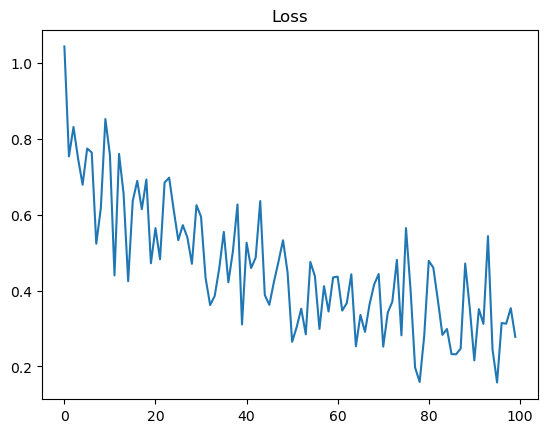

In [ ]:
num_epochs = 100

losses = []


try:
    model_validation = torch.load('Cancer_CNN_validation.pt')
    img = mpimg.imread('loss_validation.png')
    imgplot = plt.imshow(img)
    plt.show()

except:

    model_validation.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in train_dataloader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model_validation(data)
            #print(f'output: {output}')
            #print(f'target: {target.type_as(output)}\n')
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model_validation, 'Cancer_CNN_validation.pt')
        
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_validation.png')

In [ ]:
YPredict = []
YTrue = []

for data, target in tqdm(validation_dataloader):
    data = data.to(device)  
    output = model_validation(data)
    pred = int(torch.argmax(output))
    label = int(torch.argmax(target))
    YPredict.append(pred)
    YTrue.append(label)
    
print("Confusion matrix: " + str(confusion_matrix(YTrue, YPredict)))
print("Accuracy: " + str(accuracy_score(YTrue, YPredict)))
print("F1: " + str(f1_score(YTrue, YPredict, average = "macro")))


100%|██████████| 86/86 [00:00<00:00, 248.46it/s]

Confusion matrix: [[24  9  1  0  1]
 [13  6  0  0  0]
 [ 5  2  1  1  1]
 [ 8  2  2  1  1]
 [ 6  2  0  0  0]]
Accuracy: 0.37209302325581395
F1: 0.21906593406593408


In [ ]:
class CancerCNN_2(nn.Module):
    def __init__(self):
        super(CancerCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 5)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 512 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [ ]:
# Step 4: Initialize the CNN Model
model_validation_2 = CancerCNN_2().float()
print(model_validation_2)

model_validation_2 = model_validation_2.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_validation_2.parameters(), lr=0.000001)

CancerCNN_2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [ ]:
num_epochs = 100

losses = []

try:
    model_validation_2 = torch.load('Cancer_CNN_validation_2.pt')
    img = mpimg.imread('loss_validation_2.png')
    imgplot = plt.imshow(img)
    plt.show()
    
except:
    model_validation_2.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in train_dataloader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model_validation_2(data)
            #print(f'output: {output}')
            #print(f'target: {target.type_as(output)}\n')
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model_validation_2, 'Cancer_CNN_validation_2.pt')
        
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_validation_2.png')

  4%|▍         | 4/100 [00:49<19:40, 12.29s/it]


KeyboardInterrupt: 

In [ ]:
YPredict = []
YTrue = []

for data, target in tqdm(validation_dataloader):
    data = data.to(device)  
    output = model_validation_2(data)
    pred = int(torch.argmax(output))
    label = int(torch.argmax(target))
    YPredict.append(pred)
    YTrue.append(label)
    
print("Confusion matrix: " + str(confusion_matrix(YTrue, YPredict)))
print("Accuracy: " + str(accuracy_score(YTrue, YPredict)))
print("F1: " + str(f1_score(YTrue, YPredict, average = "macro")))

100%|██████████| 86/86 [00:00<00:00, 198.29it/s]

Confusion matrix: [[16  5  1  5  2]
 [12  8  2  4  0]
 [ 2  4  0  2  0]
 [ 9  3  1  4  0]
 [ 4  1  0  0  1]]
Accuracy: 0.3372093023255814
F1: 0.25141843971631206


In [ ]:
class CancerCNN_3(nn.Module):
    def __init__(self):
        super(CancerCNN_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)  # New convolutional layer

        self.fc1 = nn.Linear(1024 * 7 * 7, 2048)  # Adjusted for new layer sizes
        self.fc2 = nn.Linear(2048, 512)           # New linear layer
        self.fc3 = nn.Linear(512, 5)              # Adjusted final layer
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))  # Forward pass through the new layer
        x = x.view(-1, 1024 * 7 * 7)          # Adjust flatten step
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Step 4: Initialize the CNN Model
model_validation_3 = CancerCNN_3().float()
print(model_validation_3)

model_validation_3 = model_validation_3.to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_validation_3.parameters(), lr=0.000001)

CancerCNN_3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [ ]:
num_epochs = 100

losses = []


try:
    model_validation_3 = torch.load('Cancer_CNN_validation_3.pt')
    img = mpimg.imread('loss_validation_3.png')
    imgplot = plt.imshow(img)
    plt.show()
    
except:
    model_validation_3.train()
    for epoch in tqdm(range(num_epochs)):  # Number of epochs
        for data, target in train_dataloader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model_validation_3(data)
            #print(f'output: {output}')
            #print(f'target: {target.type_as(output)}\n')
            loss = criterion(output, target.type_as(output)) # Ensuring target is same type as output
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    torch.save(model_validation_3, 'Cancer_CNN_validation_3.pt')

    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(losses)
    plt.title('Loss')
    plt.show()
    fig.savefig('loss_validation_3.png')

  0%|          | 1/5000 [00:02<3:11:59,  2.30s/it]

Epoch 1, Loss: 1.4728567600250244


  0%|          | 2/5000 [00:04<3:11:25,  2.30s/it]

Epoch 2, Loss: 1.5079879760742188


  0%|          | 3/5000 [00:06<3:03:15,  2.20s/it]

Epoch 3, Loss: 1.5309159755706787


  0%|          | 4/5000 [00:09<3:08:31,  2.26s/it]

Epoch 4, Loss: 1.5671930313110352


  0%|          | 5/5000 [00:11<3:11:22,  2.30s/it]

Epoch 5, Loss: 1.468489408493042


  0%|          | 6/5000 [00:13<3:11:15,  2.30s/it]

Epoch 6, Loss: 1.418827772140503


  0%|          | 7/5000 [00:16<3:11:47,  2.30s/it]

Epoch 7, Loss: 1.3968137502670288


  0%|          | 8/5000 [00:18<3:15:41,  2.35s/it]

Epoch 8, Loss: 1.5922635793685913


  0%|          | 9/5000 [00:20<3:18:04,  2.38s/it]

Epoch 9, Loss: 1.4208438396453857


  0%|          | 10/5000 [00:23<3:19:11,  2.40s/it]

Epoch 10, Loss: 1.6165204048156738


  0%|          | 11/5000 [00:25<3:20:38,  2.41s/it]

Epoch 11, Loss: 1.424961805343628


  0%|          | 12/5000 [00:28<3:21:55,  2.43s/it]

Epoch 12, Loss: 1.329629898071289


  0%|          | 13/5000 [00:30<3:22:59,  2.44s/it]

Epoch 13, Loss: 1.509308099746704


  0%|          | 14/5000 [00:33<3:25:43,  2.48s/it]

Epoch 14, Loss: 1.3403127193450928


  0%|          | 15/5000 [00:36<3:31:50,  2.55s/it]

Epoch 15, Loss: 1.5304396152496338


  0%|          | 16/5000 [00:38<3:30:41,  2.54s/it]

Epoch 16, Loss: 1.4841607809066772


  0%|          | 17/5000 [00:40<3:29:12,  2.52s/it]

Epoch 17, Loss: 1.4617092609405518


  0%|          | 18/5000 [00:44<3:41:56,  2.67s/it]

Epoch 18, Loss: 1.3694181442260742


  0%|          | 19/5000 [00:46<3:45:31,  2.72s/it]

Epoch 19, Loss: 1.4969596862792969


  0%|          | 20/5000 [00:49<3:45:31,  2.72s/it]

Epoch 20, Loss: 1.5774821043014526


  0%|          | 21/5000 [00:52<3:46:37,  2.73s/it]

Epoch 21, Loss: 1.4987200498580933


  0%|          | 22/5000 [00:54<3:43:41,  2.70s/it]

Epoch 22, Loss: 1.272642970085144


  0%|          | 23/5000 [00:57<3:40:00,  2.65s/it]

Epoch 23, Loss: 1.422799825668335


  0%|          | 24/5000 [00:59<3:35:42,  2.60s/it]

Epoch 24, Loss: 1.4805091619491577


  0%|          | 25/5000 [01:02<3:32:31,  2.56s/it]

Epoch 25, Loss: 1.4847934246063232


  1%|          | 26/5000 [01:05<3:32:46,  2.57s/it]

Epoch 26, Loss: 1.4090251922607422


  1%|          | 27/5000 [01:07<3:29:43,  2.53s/it]

Epoch 27, Loss: 1.3690826892852783


  1%|          | 28/5000 [01:09<3:28:06,  2.51s/it]

Epoch 28, Loss: 1.4782794713974


  1%|          | 29/5000 [01:12<3:28:49,  2.52s/it]

Epoch 29, Loss: 1.5621951818466187


  1%|          | 30/5000 [01:14<3:28:39,  2.52s/it]

Epoch 30, Loss: 1.5140812397003174


  1%|          | 31/5000 [01:17<3:30:00,  2.54s/it]

Epoch 31, Loss: 1.361342430114746


  1%|          | 32/5000 [01:20<3:31:13,  2.55s/it]

Epoch 32, Loss: 1.4695886373519897


  1%|          | 33/5000 [01:22<3:30:48,  2.55s/it]

Epoch 33, Loss: 1.4562476873397827


  1%|          | 34/5000 [01:25<3:32:04,  2.56s/it]

Epoch 34, Loss: 1.5070271492004395


  1%|          | 35/5000 [01:27<3:30:42,  2.55s/it]

Epoch 35, Loss: 1.1572242975234985


  1%|          | 36/5000 [01:30<3:29:41,  2.53s/it]

Epoch 36, Loss: 1.3912487030029297


  1%|          | 37/5000 [01:32<3:27:24,  2.51s/it]

Epoch 37, Loss: 1.497622013092041


  1%|          | 38/5000 [01:35<3:27:52,  2.51s/it]

Epoch 38, Loss: 1.6075475215911865


  1%|          | 39/5000 [01:37<3:27:17,  2.51s/it]

Epoch 39, Loss: 1.3727061748504639


  1%|          | 40/5000 [01:40<3:26:48,  2.50s/it]

Epoch 40, Loss: 1.4267723560333252


  1%|          | 41/5000 [01:42<3:26:37,  2.50s/it]

Epoch 41, Loss: 1.612127661705017


  1%|          | 41/5000 [01:45<3:31:48,  2.56s/it]


KeyboardInterrupt: 

In [ ]:
YPredict = []
YTrue = []

for data, target in tqdm(validation_dataloader):
    data = data.to(device)  
    output = model_validation_3(data)
    pred = int(torch.argmax(output))
    label = int(torch.argmax(target))
    YPredict.append(pred)
    YTrue.append(label)
    
print("Confusion matrix: " + str(confusion_matrix(YTrue, YPredict)))
print("Accuracy: " + str(accuracy_score(YTrue, YPredict)))
print("F1: " + str(f1_score(YTrue, YPredict, average = "macro")))